# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [100]:
# !pip install implicit

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender
from tqdm import tqdm

tqdm.pandas()

In [102]:
data = pd.read_csv('../raw_data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# Если я не ошибаюсь, предобработку данных на датасете 
# лучше выполнять до разделения, выборки. 
# data = prefilter_items(data, item_features=item_features, take_n_popular=5000)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [103]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [104]:
recommender = MainRecommender(data_train_lvl_1)

100%|██████████| 5001/5001 [00:00<00:00, 91158.33it/s]


In [105]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1037863, 951590, 1044078, 991546]

In [106]:
recommender.get_own_recommendations(2375, N=5)

[1068562, 1005935, 907099, 1112627, 1036501]

In [107]:
is_extend_with_top_popular=True
recommender.get_own_recommendations(user=2375, N=5, extend_with_top_popular=is_extend_with_top_popular)

[1068562, 1005935, 907099, 1112627, 1036501]

In [108]:
recommender.get_similar_items_recommendation(2375, N=5)

[889731, 1044078, 999207, 1062966, 9677366]

In [109]:
recommender.get_similar_users_recommendation(2375, N=5)

[1052155, 831125, 854133, 7147317, 911162]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [ ]:
data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [110]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [111]:
# Убирем из тестовой выборки пользоватлей, которые отсутствуют в обучащей. 
# Определяем уникальных пользователей которые есть в тестовом датасете. 

result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1['user_id'].unique())]
result_lvl_1['user_id'].count()

2084

In [112]:
N=50
result_lvl_1['similar_items_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))

result_lvl_1['als_recmender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))

result_lvl_1['own_recomender'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

# Дополняем недостающие товары популярными.
is_extend_with_top_popular=True
result_lvl_1['own_recomender_extend'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N, extend_with_top_popular=is_extend_with_top_popular))

In [113]:
N=50
precision_dic = {'method':[], 'precission':[] }

column_names = ['similar_items_recomender',
                'als_recmender',
                'own_recomender',
                'own_recomender_extend'
]
for column_name in column_names:
    precision_dic['method'].append(column_name)
    precision_dic['precission'].append(result_lvl_1.apply(lambda x: precision_at_k(x[column_name], x['actual'],  N), axis=1).mean()) 

pd.DataFrame(precision_dic)

,method,precission
0,similar_items_recomender,0.057342
1,als_recmender,0.080163
2,own_recomender,0.118695
3,own_recomender_extend,0.118695


**B)**\* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  

In [114]:
precision = []
is_extend_with_top_popular=True
for k in tqdm([5, 10, 20, 50, 100, 200, 500]):
    result_lvl_1[f'own_recomender_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender. \
    get_own_recommendations(x, N=k,extend_with_top_popular=is_extend_with_top_popular))
    precision.append(result_lvl_1.apply(lambda x: precision_at_k(x[f'own_recomender_{k}'],
    x['actual'],  k), axis=1).mean()) 

100%|██████████| 7/7 [00:28<00:00,  4.02s/it]


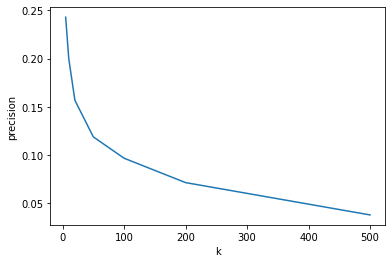

In [115]:
plt.plot([5, 10, 20, 50, 100, 200, 500], precision)
plt.ylabel('precision')
plt.xlabel('k')
plt.show()

**C)*** Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

На графике видно, что с ростом к-ва рекомндуемых товров к-во падает.
Кроме того, если брать большое к-во товаров для рекомендации, они не будут помещаться в соответствующую строку на странице магазина. И велика вероятность, что пользователь х даже не увидит. Поэтому - 5-7 товаров, на мой взгляд будет оптимальным к-вом. Максимум 10.

### Задание 2.

Обучите модель 2-ого уровня, при этом:  
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар  
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2  
    - Вырос ли precision@5 при использовании двухуровневой модели?  

In [127]:
# result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
# result_lvl_2.columns=['user_id', 'actual']

# result_lvl_2 = result_lvl_2[result_lvl_2['user_id'].isin(data_train_lvl_1['user_id'].unique())]
# result_lvl_2['user_id'].count()
# result_lvl_2.head(2)

In [128]:
N=50
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(data_train_lvl_1['user_id'].unique())]

# Заполняем кандидатов, на основе предсказания модели 1-го уровня.
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))

In [129]:
# test_users = data

In [130]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная переменная

users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,834103,1
0,2070,1092937,1
0,2070,1077410,1
0,2070,936508,1


In [131]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [132]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,834103,1.0
1,2070,834103,1.0


In [133]:
targets_lvl_2['target'].mean()

0.1782244886965578

In [134]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [135]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [136]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [137]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [138]:
X_train

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,834103,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,834103,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,834103,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,834103,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,834103,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111377,1745,1082185,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
111378,1745,1106523,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
111379,1745,1133018,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
111380,1745,981760,69,GROCERY,Private,EGGS,EGGS - X-LARGE,1 DZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown


In [139]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [140]:
y_train.mean()

target    0.178224
dtype: float64

In [141]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

C:\Users\eveli\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eveli\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\eveli\AppData\Local\Programs\Python\Python38\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [143]:
train_preds

array([[0.29047754, 0.70952246],
       [0.29047754, 0.70952246],
       [0.29047754, 0.70952246],
       ...,
       [0.79547517, 0.20452483],
       [0.76256024, 0.23743976],
       [0.80666864, 0.19333136]])

In [142]:
# x_test

NameError: name 'x_test' is not defined

In [ ]:
# y_test

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 